In [384]:
from copy import deepcopy
from itertools import combinations
import typing as tp

import numpy as np
import pandas as pd
from numpy.linalg import lstsq
from scipy.optimize import linprog
from matplotlib import pyplot as plt
import statsmodels.api as sm

from citk.layer import Dense, FuzzyGMDHLayer
from citk.model import FFN, GMDH
from citk.functions import ReLU, Linear, BellMembership, GaussianMembership, Poly
from citk.losses import MSE, FMSE, RMSE, MAPE
from citk.optimisers import SGDOptimizer

from utils import seed_everything, create_lags

In [385]:
import seaborn as sns
sns.set()

In [386]:
RANDOM_SEED = 42
seed_everything(RANDOM_SEED)

columns_to_keep = ["Open", "Close", "Volume", "Low", "High", "Date"]
data = pd.read_csv("../data/nasdaq_2021.csv", usecols=columns_to_keep)
data.head(5)

,Date,Open,High,Low,Close,Volume
0,2020-12-31,12877.089844,12902.070313,12821.230469,12888.280273,4771390000
1,2021-01-04,12958.519531,12958.719727,12543.240234,12698.450195,6546740000
2,2021-01-05,12665.650391,12828.269531,12665.650391,12818.959961,6904420000
3,2021-01-06,12666.150391,12909.629883,12649.990234,12740.790039,7648340000
4,2021-01-07,12867.339844,13090.910156,12867.339844,13067.480469,6777010000


In [387]:
data_rolling = data.ewm(7).mean()

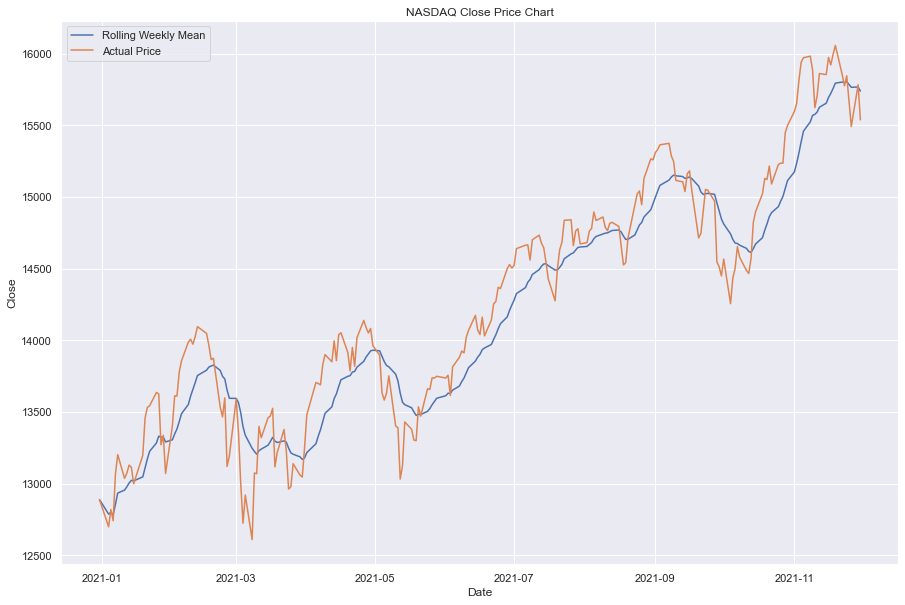

In [388]:
plt.figure(figsize=(15, 10))
plt.title('NASDAQ Close Price Chart')
sns.lineplot(data=data_rolling, x=pd.to_datetime(data.Date), y='Close', label="Rolling Weekly Mean")
sns.lineplot(data=data, x=pd.to_datetime(data.Date), y='Close', label="Actual Price")
plt.legend()
plt.show()

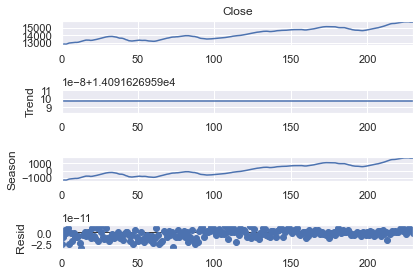

In [389]:
from statsmodels.tsa.seasonal import STL
res = STL(data_rolling.Close, period=365).fit()
res.plot()
plt.show()

In [390]:
data['diff_Close'] = data.Close-data_rolling.Close
data['diff_Open'] = data.Open-data_rolling.Open

<AxesSubplot:ylabel='diff_Close'>

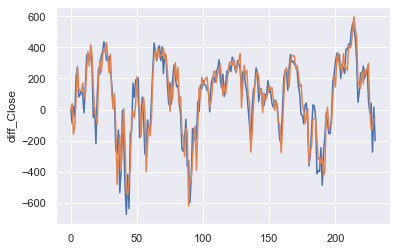

In [391]:
sns.lineplot(data=data, x=data.index, y='diff_Close')
sns.lineplot(data=data, x=data.index, y='diff_Open')

In [392]:
sm.tsa.stattools.adfuller(data.diff_Close, regression='c')

(-4.556706307398623,
 0.00015510333906630975,
 0,
 230,
 {'1%': -3.459105583381277,
  '5%': -2.8741898504150574,
  '10%': -2.5735117958412097},
 2714.866629636089)

/Users/dmytroandrosov/miniforge3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/Users/dmytroandrosov/miniforge3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


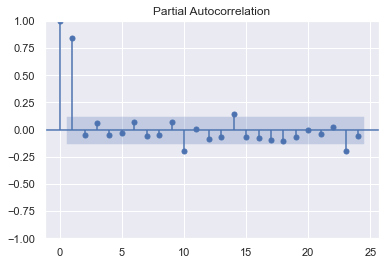

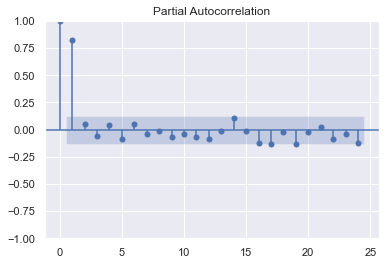

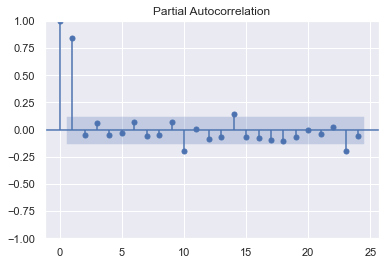

In [393]:
sm.graphics.tsa.plot_pacf(data['diff_Close'].fillna(0))
sm.graphics.tsa.plot_pacf(data['diff_Open'].fillna(0))

In [394]:
def normalize_dataset(train_dataset: pd.DataFrame, test_dataset: pd.DataFrame) -> pd.DataFrame:
    train_dataset_min = train_dataset.min()
    train_dataset_max = train_dataset.max()
    tr_ds = (train_dataset-train_dataset_min)/(train_dataset_max-train_dataset_min)
    test_ds = (test_dataset-train_dataset_min)/(train_dataset_max-train_dataset_min)
    return tr_ds, test_ds

In [395]:
data = data[["Open", "Close", "Volume", "Low", "High"]]

In [343]:
n_lags = 5
test_len = 30
data = data[["Open", "Close", "Volume", "Low", "High"]]
train_df, test_df = data.iloc[-2*test_len-n_lags-15:-test_len-n_lags], data.iloc[-test_len-n_lags:]

In [344]:
train_df, test_df = normalize_dataset(train_df, test_df)

In [345]:
train_df, test_df = create_lags(
    train_df, test_df, 
    ["Close", "Open", "Low", "High", "Volume"], 
    n_lags
)

In [347]:
y_col = "Close"
X_col = train_df.columns.tolist()
X_col.remove(y_col)

X_train = train_df[X_col].values
X_test = test_df[X_col].values
y_train = train_df[y_col].values[..., np.newaxis]
y_test = test_df[y_col].values[..., np.newaxis]

In [348]:
model = GMDH(
            method_type='neo_fuzzy', 
            loss=MSE,
            num_rules=8,
            num_sgd_rounds=700
        )

In [349]:
import time
bt = time.time()
model, history  = model.fit(
    (X_train, y_train),
    (X_test, y_test),
    max_gmdh_layers=10,
    n_best_to_take=10,
    verbose=True,
)
et = time.time()

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/406 [00:00<?, ?it/s]

Layer: 0. Metric: 0.010873098054721603


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.01673076739595858
110.97214889526367


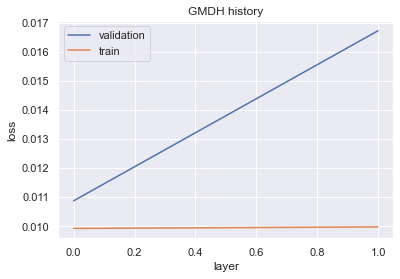

In [351]:
plt.title('GMDH history')
plt.plot(history['validation_loss'], label='validation')
plt.plot(history['train_loss'], label='train')
plt.xlabel('layer')
plt.ylabel('loss')
plt.legend()
plt.show()

In [352]:
bt = time.time()
prediction = model.predict(X_test)
et = time.time()
prediction_train = model.predict(X_train

0.0006818771362304688


In [396]:
def make_forecast(model, interval: int, data) -> np.ndarray:
    y_col = "Close"
    X_col = data.columns.tolist()
    X_col.remove(y_col)
    max_order = [int(lag_name[-1]) for lag_name in X_col if lag_name.startswith(y_col)][-1]
    if interval==1:
        return model.predict(data[X_col].values)
    prediction = []
    start_int = 0
    end_int = interval
    num_all_rows = data.shape[0]
    while start_int < end_int:
        test_data = data.iloc[start_int: end_int].reset_index(drop=True).copy()
        num_rows = test_data.shape[0]
        start_int += interval
        end_int = min(start_int + interval, num_all_rows)
        for rownum in range(num_rows):
            batch_to_predict = test_data[X_col].values[rownum:rownum+1]
            y_pred = model.predict(batch_to_predict)[0][0]
            prediction.append(y_pred)
            for rn in range(max_order):
                if rn+rownum+1 < num_rows:
                    test_data.at[rn+rownum+1, f"{y_col}_{rn+1}"] = y_pred
    return np.array(prediction).reshape(-1,1)

In [371]:
prediction = make_forecast(model, 7, test_df)

In [364]:
test_df.shape, prediction.shape

((30, 30), (30, 1))

In [365]:
print(f"Test RMSE: {RMSE(y_test, prediction)[0]}")
print(f"Test MAPE: {MAPE(y_test, prediction)[0] * 100 : .6f}%")
print(f"Train RMSE: {RMSE(y_train, prediction_train)[0]}")
print(f"Train MAPE: {MAPE(y_train, prediction_train)[0] * 100 : .6f}%")

Test RMSE: 0.10427414854469733
Test MAPE:  0.243737%
Train RMSE: 0.0996026493925783
Train MAPE:  0.457775%


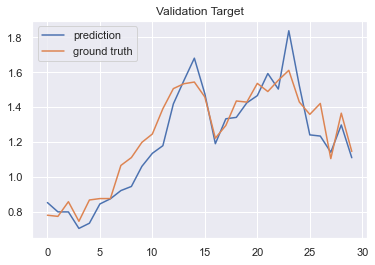

In [366]:
plt.title('Validation Target')
plt.plot(prediction, label='prediction')
plt.plot(y_test, label='ground truth')
plt.legend()
plt.show()

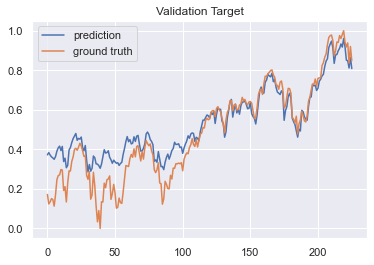

In [367]:
test_global, _ = create_lags(
    data, data, 
    ["Close", "Open", "Low", "High", "Volume"], 
    n_lags
)
test_global, _ = normalize_dataset(test_global, _)
y_col = "Close"
X_col = test_global.columns.tolist()
X_col.remove(y_col)

X_test = test_global[X_col].values
y_test = test_global[y_col].values[..., np.newaxis]

prediction = model.predict(X_test)
plt.title('Validation Target')
plt.plot(prediction, label='prediction')
plt.plot(y_test, label='ground truth')
plt.legend()
plt.show()

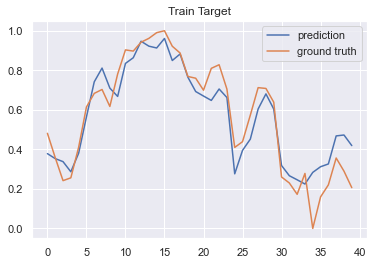

In [369]:
plt.title('Train Target')
plt.plot(prediction_train, label='prediction')
plt.plot(y_train, label='ground truth')
plt.legend()
plt.show()

In [397]:
def brute_force_metrics(dataset: pd.DataFrame, num_rules: tp.List[int], forecast_intervals: tp.List[int], sliding_window_size: tp.List[int]) -> pd.DataFrame:
    res_dict = dict(n_rules=[], window_size=[], forecast_intervals=[], rmse_neofuzzy=[], mape_neofuzzy=[], rmse_neurofuzzy=[], mape_neurofuzzy=[])
    for sliding_window in sliding_window_size:
        train_df, test_df = data.iloc[-3*30-sliding_window:-30-sliding_window], data.iloc[-30-sliding_window:]
        train_df, test_df = normalize_dataset(train_df, test_df)
        train_df, test_df = create_lags(
                train_df, test_df, 
                ["Close", "Open", "Low", "High", "Volume"], 
                sliding_window
            )
        y_col = "Close"
        X_col = train_df.columns.tolist()
        X_col.remove(y_col)

        X_train = train_df[X_col].values
        X_test = test_df[X_col].values
        y_train = train_df[y_col].values[..., np.newaxis]
        y_test = test_df[y_col].values[..., np.newaxis]
        
        print(f"sliding window = {sliding_window}, X shape = {X_train.shape[1]}")
        
        for n_rules in num_rules:
            print(f"num rules = {n_rules}")
            model_neofuzzy = GMDH(
                    method_type='neo_fuzzy', 
                    loss=MSE,
                    num_rules=n_rules,
                    num_sgd_rounds=500,
                )
            
            model_neofuzzy, _  = model_neofuzzy.fit(
                (X_train, y_train),
                (X_test[:7], y_test[:7]),
                max_gmdh_layers=10,
                n_best_to_take=10,
                verbose=True,
                )
            
            model_neurofuzzy = GMDH(
                    method_type='neuro_fuzzy', 
                    loss=MSE,
                    num_rules=n_rules,
                    num_sgd_rounds=500
                )
            model_neurofuzzy, _  = model_neurofuzzy.fit(
                (X_train, y_train),
                (X_test[:7], y_test[:7]),
                max_gmdh_layers=10,
                n_best_to_take=10,
                verbose=True,
                )
            
            for fint in forecast_intervals:
                res_dict['n_rules'].append(n_rules)
                res_dict['window_size'].append(sliding_window)
                res_dict['forecast_intervals'].append(fint)
                
                prediction = make_forecast(model_neofuzzy, fint, test_df)
                res_dict['rmse_neofuzzy'].append(RMSE(y_test, prediction)[0])
                res_dict['mape_neofuzzy'].append(MAPE(y_test, prediction)[0])
                
                prediction = make_forecast(model_neurofuzzy, fint, test_df)
                res_dict['rmse_neurofuzzy'].append(RMSE(y_test, prediction)[0])
                res_dict['mape_neurofuzzy'].append(MAPE(y_test, prediction)[0])
                
            del model_neofuzzy
            del model_neurofuzzy
                
    df = pd.DataFrame(res_dict)
    return df                

In [398]:
df = brute_force_metrics(data, num_rules=range(2, 10), forecast_intervals=[1], sliding_window_size=range(1,6))

sliding window = 1, X shape = 9
num rules = 2


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

Layer: 0. Metric: 0.003731081778857181


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.003617508554376238


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.0023985781844540303


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 3. Metric: 0.0026479580783395147


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0038479440135732075


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0032380056840562374


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.002952704237601683


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 3. Metric: 0.0017421942004759087


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 4. Metric: 0.0030312146653959345
num rules = 3


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0022917951579010283


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.002222600845409405


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.002052393902101388


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 3. Metric: 0.0013105586077797906


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 4. Metric: 0.0017882351848947078


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

Layer: 0. Metric: 0.007401493015169366


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.005142287544341497


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.003557053448413994


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 3. Metric: 0.004415702993588219
num rules = 4


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

Layer: 0. Metric: 0.003038109940428001


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.002520481999794883


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.0025540733328662337


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

Layer: 0. Metric: 0.002870272212701642


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0026196989102091656


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.0023303652070009407


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 3. Metric: 0.0030018190487094676
num rules = 5


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0016184927989473922


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0017113260648651976


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

Layer: 0. Metric: 0.004741997029726002


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.003006900809129347


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.002271044397837394


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 3. Metric: 0.002347845938952219
num rules = 6


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0009868558723968167


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.002151248906460173


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0034458866662670936


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0038217729262816124
num rules = 7


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

Layer: 0. Metric: 0.002974686491408676


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.001532811508818712


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.0014363953814949555


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 3. Metric: 0.0013194227515766904


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 4. Metric: 0.0009082081281096096


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 5. Metric: 0.0006888734295659717


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 6. Metric: 0.00034949322815552766


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 7. Metric: 0.00029403733575464336


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 8. Metric: 0.00032146674311370367


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

Layer: 0. Metric: 0.00271719237035834


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0024637246595655346


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.0025488429802689827
num rules = 8


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0020788169062794623


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.001836878168511628


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.0017588909899195078


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 3. Metric: 0.0014755754642250664


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 4. Metric: 0.0010357699679615527


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 5. Metric: 0.0010003414710353833


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 6. Metric: 0.0009885687166021218


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 7. Metric: 0.000545942529896632


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 8. Metric: 0.0007390939892245294


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0044359219754511545


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.002288562661288354


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.0027034891724737223
num rules = 9


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

Layer: 0. Metric: 0.001320916072757373


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.002333569571096481


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

Layer: 0. Metric: 0.002745879545349102


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.003332088552834091
sliding window = 2, X shape = 14
num rules = 2


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/91 [00:00<?, ?it/s]

Layer: 0. Metric: 0.002643414497173222


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0029300641654642673


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/91 [00:00<?, ?it/s]

Layer: 0. Metric: 0.002882552630330199


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0017314877991554405


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.002115549634182468
num rules = 3


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/91 [00:00<?, ?it/s]

Layer: 0. Metric: 0.002644550451056471


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.002202853117195868


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.0020896095901908524


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 3. Metric: 0.002183334156865738


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/91 [00:00<?, ?it/s]

Layer: 0. Metric: 0.003847048953009242


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.002161164406935583


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.0024522043440929507
num rules = 4


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/91 [00:00<?, ?it/s]

Layer: 0. Metric: 0.001847306413266629


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0021476512445338463


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/91 [00:00<?, ?it/s]

Layer: 0. Metric: 0.002662887544025925


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0023376504631826395


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.0026173966262183746
num rules = 5


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/91 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0017792654674462802


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0012389843566737503


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.00134651831560875


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/91 [00:00<?, ?it/s]

Layer: 0. Metric: 0.002749366463546853


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0022611926306550212


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.003094918448870548
num rules = 6


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/91 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0012196131684835052


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0016378134994128536


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/91 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0012192326064908515


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0022708557352176797
num rules = 7


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/91 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0017640499309965869


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0010502192799182858


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.000910653011508956


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 3. Metric: 0.0014481348293926804


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/91 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0020880756341744686


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.002166415789550078
num rules = 8


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/91 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0012927983108256564


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0013665835374953447


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/91 [00:00<?, ?it/s]

Layer: 0. Metric: 0.002075064299988355


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0028835322757364834
num rules = 9


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/91 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0027560402003271116


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0015990621910250253


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.0013278859991748204


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 3. Metric: 0.0009872835073189096


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 4. Metric: 0.001238403544659149


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/91 [00:00<?, ?it/s]

Layer: 0. Metric: 0.002534520101012866


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.001089962267385272


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.0009049893427031819


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 3. Metric: 0.0016688485967683829
sliding window = 3, X shape = 19
num rules = 2


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/171 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0028427834396391495


IOStream.flush timed out
IOStream.flush timed out


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0023286697733777015


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.0024234013163592335


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/171 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0037230724600859


IOStream.flush timed out
IOStream.flush timed out


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.002104324367273052


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.002136452552265835
num rules = 3


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/171 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0021817443833432866


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.002909307163605474


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/171 [00:00<?, ?it/s]

Layer: 0. Metric: 0.003720271903900111


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0027842373702654938


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.0014193223099540375


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 3. Metric: 0.0017309186636744708
num rules = 4


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/171 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0006624943554384897


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0019673162802056345


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/171 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0022506909883550966


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.001809059631502255


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.002501487044601955
num rules = 5


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/171 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0024159574345102757


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.000806579940919902


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.001119668035093084


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/171 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0037140908269403293


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0011343663829003964


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.0013623887680930585
num rules = 6


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/171 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0017569095045485276


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0013222252039179394


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.0013599004276008378


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/171 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0015542444000538273


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0024482900884823925
num rules = 7


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/171 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0011754195244034565


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0011457171424650678


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.0010901289610333144


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 3. Metric: 0.0012051349686685038


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/171 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0016364466848242983


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0019741212766002636
num rules = 8


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/171 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0014270635644320921


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0010458460317661197


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.0006904960944061165


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 3. Metric: 0.0008173650301718398


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/171 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0012592375590122218


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0015353822880357026
num rules = 9


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/171 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0019719880678218302


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.002174726054301812


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/171 [00:00<?, ?it/s]

Layer: 0. Metric: 0.00158514371160011


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.003265739246543119
sliding window = 4, X shape = 24
num rules = 2


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/276 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0018297923584528267


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0009833095350446582


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.0009650579713892644


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 3. Metric: 0.001858332866728715


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/276 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0012122540945137647


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.001965434500283053
num rules = 3


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/276 [00:00<?, ?it/s]

Layer: 0. Metric: 0.001471979143120993


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0027011877816911062


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/276 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0016662059714581084


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.002673565555215123
num rules = 4


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/276 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0014236826182273496


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0017009354434870737


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/276 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0015870427325403828


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.002455247135852676
num rules = 5


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/276 [00:00<?, ?it/s]

Layer: 0. Metric: 0.001836799355961418


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0010600020597399571


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.0009095642961076253


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 3. Metric: 0.0008190062340729683


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 4. Metric: 0.0012369527968316002


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/276 [00:00<?, ?it/s]

Layer: 0. Metric: 0.003217391944858556


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.001409335198567157


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.0016643237322559094
num rules = 6


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/276 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0012520876476305313


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0010397696391916068


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.0012496601700574587


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/276 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0026439483770424378


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.001934490745555201


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.0011260308240821882


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 3. Metric: 0.002478831747996184
num rules = 7


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/276 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0019402752993693804


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0008516250655479814


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.0009298186884266795


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/276 [00:00<?, ?it/s]

Layer: 0. Metric: 0.002272157541446038


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0029972644013158086
num rules = 8


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/276 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0017917150867238466


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.001331283500979776


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.0008318732476043593


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 3. Metric: 0.0007766045984811943


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 4. Metric: 0.0008682850811160726


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/276 [00:00<?, ?it/s]

Layer: 0. Metric: 0.002460294204002857


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0027431072149030323
num rules = 9


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/276 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0014179626190742108


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0012148926600510437


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.0014258876048052582


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/276 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0018260918219215518


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0016185262437313972


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.0022132259123911276
sliding window = 5, X shape = 29
num rules = 2


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/406 [00:00<?, ?it/s]

IOStream.flush timed out
IOStream.flush timed out


Layer: 0. Metric: 0.002166617699521874


IOStream.flush timed out
IOStream.flush timed out


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0013251182424724097


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.002022493334165094


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/406 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0031736219947304726


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.002393422207062191


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.0019487676282328153


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 3. Metric: 0.002056788457156571
num rules = 3


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/406 [00:00<?, ?it/s]

Layer: 0. Metric: 0.002732063213551811


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0009923739660735145


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.0013165652668131053


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/406 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0016406213010049491


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.002619128104970804
num rules = 4


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/406 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0009627749575226232


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0016836240987034485


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/406 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0018378929200354493


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0016644193668679827


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.0007763274981245625


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 3. Metric: 0.001027161747579545
num rules = 5


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/406 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0007252562681123324


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.001090735842379066


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/406 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0020630709470518837


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0011540054456985742


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.0008610697391815755


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 3. Metric: 0.00236628629701727
num rules = 6


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/406 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0008087813725877399


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0015893768545572964


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/406 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0022236554698047716


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0009121692079709392


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.0010044861261907332
num rules = 7


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/406 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0007126169534782236


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0007449341065175204


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/406 [00:00<?, ?it/s]

Layer: 0. Metric: 0.001049303185992889


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0016029793103664509
num rules = 8


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/406 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0011399787817177596


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0008108692634727413


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.0008368112404333889


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/406 [00:00<?, ?it/s]

Layer: 0. Metric: 0.002193510549675544


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0010431321750166574


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.0015879245027317346
num rules = 9


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/406 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0013051644499721383


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0009264154304655692


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.0009655710110100194


Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/406 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0018707861963026464


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 1. Metric: 0.0017305684183977024


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 2. Metric: 0.0014387463914163543


One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Layer: 3. Metric: 0.002179493814100254


In [399]:
df.to_csv("results.csv", index=False)

In [371]:
for ip, p in enumerate(model.predict_history['pairs']):
    if ip<1:
        cols = X_col
    else:
        cols = [f'y_{ip}_{i+1}' for i in range(10)]
    print(f"Layer {ip+1}\n Features:\t")
    for pair in p:
        print(f"({cols[pair[0]]}, {cols[pair[1]]})", end=", ")
    print()

Layer 1
 Features:	
(Low, Low_2), (Low, High), (Low, Open_4), (Low_1, Low_4), (High, Open_3), (Open, Low_2), (High, High_4), (Close_1, Low_4), (Open, Volume_1), (Close_2, Volume_3), 
Layer 2
 Features:	
(y_1_5, y_1_9), (y_1_2, y_1_5), (y_1_4, y_1_9), (y_1_1, y_1_10), (y_1_5, y_1_7), (y_1_6, y_1_8), (y_1_4, y_1_10), (y_1_5, y_1_6), (y_1_5, y_1_8), (y_1_1, y_1_9), 
